<center>
    <h2>ALTeGraD 2023<br>Lab Session 5: Deep Learning for Graphs (1/2)</h2> 14 / 11 / 2023<br>Lecture: Prof. Michalis Vazirgiannis <br>
Lab: Dr. Giannis Nikolentzos & Dr. Johannes Lutzeyer <br> <br>
<b>Student name:</b> Simon Queric
</center>

## Part 1

In [1]:
import numpy as np
import networkx as nx
from random import randint
from random import shuffle
from gensim.models import Word2Vec
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):
    v = node
    walk = [node]
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(v))
        k = randint(0, len(neighbors)-1)
        walk.append(neighbors[k])
    
    walk = [str(node) for node in walk]
    return walk


############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    n_total_walks = num_walks*len(G.nodes)
    walks = []
    
    for k in range(num_walks) :
        for node in G.nodes : 
            walks.append(random_walk(G, node, walk_length))
    
    indices = np.random.choice(np.arange(n_total_walks), size=n_total_walks, replace=False)
    permuted_walks = [walks[i] for i in indices] 
    return permuted_walks #.tolist()


# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

In [5]:
# Loads the web graph
G = nx.read_weighted_edgelist('code/data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

model = deepwalk(G, n_walks, walk_length, n_dim)

Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


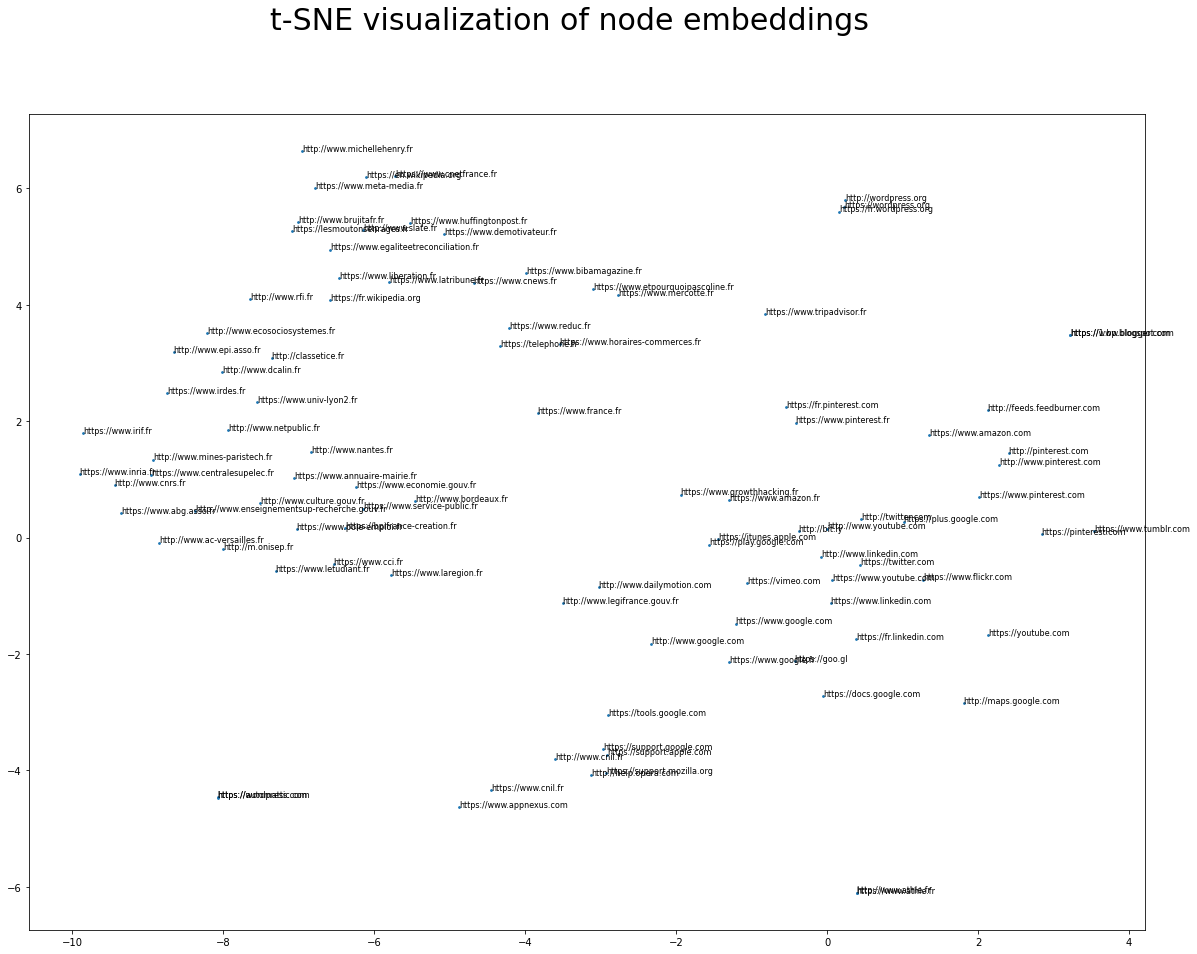

In [6]:
############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = [model.wv.index_to_key[i] for i in range(n)]
    DeepWalk_embeddings = np.empty(shape=(n, dim))
    
    for i in range(n) :
        DeepWalk_embeddings[i] = model.wv[nodes[i]]


    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')  
    plt.show()


visualize(model, 100, n_dim)

Number of nodes: 34
Number of edges: 78


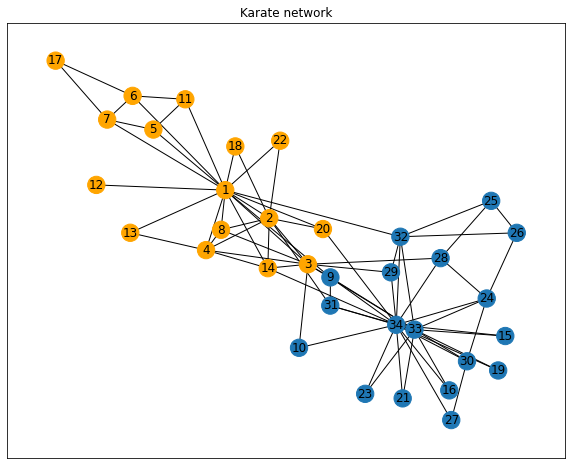

In [7]:
# Loads the karate network
G = nx.read_weighted_edgelist('code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
color = {0: "orange", 1: "#1f77b4"}
c = [color[x] for x in y]

############## Task 5
# Visualizes the karate network

fig = plt.figure(figsize=(10, 8))
plt.title("Karate network")
nx.draw_networkx(G,node_color=c, with_labels=True)
plt.show()

In [8]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
model = deepwalk(G, n_walks, walk_length, n_dim)

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]

Generating walks
Training word2vec


In [11]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions

clf = LogisticRegression().fit(X_train, y_train)
print("Accuracy of Logistic Regression classifier :", accuracy_score(clf.predict(X_test), y_test))

Accuracy of Logistic Regression classifier : 1.0


In [74]:
############## Task 8
# Generates spectral embeddings

A = nx.adjacency_matrix(G)
D = np.array([len(list(G.neighbors(v))) for v in G.nodes])
L = np.diag(D) - A
d, v = np.linalg.eigh(Lrw)
X_train = v[idx_train,:2]
X_test = v[idx_test,:2]

# Logistic regression classifier and use it to make predictions
clf = LogisticRegression().fit(X_train, y_train)
print("Accuracy of Logistic Regression classifier : {:.3f}".format(accuracy_score(clf.predict(X_test), y_test)))

Accuracy of Logistic Regression classifier : 0.857


## Part 2

In [2]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

In [3]:
np.sum([[1, 2, -5],
        [1, 2, -5]], axis=1)

array([-2, -2])

In [15]:
d = np.random.uniform(size=10)
d = sp.csr_matrix(np.diag(d))

In [20]:
i = sp.eye(10)@np.random.uniform(size=10)

In [48]:
def normalize_adjacency(A):
    ############## Task 9

    shape = A.get_shape()
    A_tilde = A + sp.eye(shape[0])
    D_sqrt = sp.diags((1/np.sqrt(A_tilde.sum(axis=1))).T, [0], shape=shape)    
    A_normalized = D_sqrt @ A_tilde @ D_sqrt

    return A_normalized


def load_cora():
    idx_features_labels = np.genfromtxt("code/data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("code/data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [40]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        
        z1 = self.relu(self.fc1(torch.mm(adj, x_in)))
        z1 = self.dropout(z1)
        output_2 = self.fc2(torch.mm(adj, z1))
        z2 = self.relu(self.fc2(torch.mm(adj, z1)))
        x = self.fc3(z2)


        return F.log_softmax(x, dim=1), output_2

In [41]:
W0 = np.array([0.5, -0.2])
W1 = np.array([[0.3, -0.4, 0.8, 0.5],
               [-1.1, 0.6, -0.1, 0.7]])
def forward(A, X) :
    X = np.ones(4)
    Z0 = np.maximum(np.einsum("i, j -> ij", A@X, W0), 0)
    Z1 = np.maximum(A@Z0@W1, 0)
    return Z1
# Star Graph S_4
A = np.array([[1, 1, 1, 1],
            [1, 1, 0, 0], 
            [1, 0, 1, 0], 
            [1, 0, 0, 1]])
D = np.sqrt(np.diag([4, 2, 2, 2]))
A = D@A@D
X = np.ones(4)
Z1 = forward(A, X)
print("Embedding for a star graph :")
print(Z1)
print("\n")
# Cycle graph C_4
A = np.array([[1, 1, 0, 0],
            [0, 1, 1, 0], 
            [0, 0, 1, 1], 
            [1, 0, 0, 1]])
D = np.sqrt(np.diag([2, 2, 2, 2]))
A = D@A@D
Z1 = forward(A, X)
print("Embedding for a cycle graph :") 
print(Z1)


Embedding for a star graph :
[[13.63675324  0.         36.3646753  22.72792206]
 [ 6.74558441  0.         17.9882251  11.24264069]
 [ 6.74558441  0.         17.9882251  11.24264069]
 [ 6.74558441  0.         17.9882251  11.24264069]]


Embedding for a cycle graph :
[[2.4 0.  6.4 4. ]
 [2.4 0.  6.4 4. ]
 [2.4 0.  6.4 4. ]
 [2.4 0.  6.4 4. ]]


In [42]:
#Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('code/data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('code/data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

print(len(G.nodes))

n=len(G.nodes)

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features

features = np.ones((n,n))

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output, _ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, _ = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

34
78
34
Epoch: 001 loss_train: 0.7096 acc_train: 0.4444 time: 0.0015s
Epoch: 002 loss_train: 0.6966 acc_train: 0.4444 time: 0.0012s
Epoch: 003 loss_train: 0.6941 acc_train: 0.4444 time: 0.0012s
Epoch: 004 loss_train: 0.6928 acc_train: 0.5556 time: 0.0011s
Epoch: 005 loss_train: 0.6900 acc_train: 0.5556 time: 0.0012s
Epoch: 006 loss_train: 0.6993 acc_train: 0.5556 time: 0.0014s
Epoch: 007 loss_train: 0.6858 acc_train: 0.5556 time: 0.0014s
Epoch: 008 loss_train: 0.6954 acc_train: 0.5556 time: 0.0019s
Epoch: 009 loss_train: 0.6731 acc_train: 0.5556 time: 0.0019s
Epoch: 010 loss_train: 0.6845 acc_train: 0.5556 time: 0.0024s
Epoch: 011 loss_train: 0.7027 acc_train: 0.5556 time: 0.0018s
Epoch: 012 loss_train: 0.6961 acc_train: 0.5556 time: 0.0016s
Epoch: 013 loss_train: 0.6829 acc_train: 0.5556 time: 0.0015s
Epoch: 014 loss_train: 0.6907 acc_train: 0.5556 time: 0.0012s
Epoch: 015 loss_train: 0.6882 acc_train: 0.5926 time: 0.0012s
Epoch: 016 loss_train: 0.6862 acc_train: 0.6667 time: 0.0010s

/tmp/ipykernel_13724/619012749.py:4: DeprecationWarning: `get_shape` is deprecated and will be removed in v1.13.0; use `X.shape` instead.
  shape = A.get_shape()


Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9533 acc_train: 0.0683 loss_val: 1.9420 acc_val: 0.2731 time: 0.0336s
Epoch: 002 loss_train: 1.9360 acc_train: 0.3147 loss_val: 1.9271 acc_val: 0.2731 time: 0.0348s
Epoch: 003 loss_train: 1.9194 acc_train: 0.3147 loss_val: 1.9111 acc_val: 0.2731 time: 0.0350s
Epoch: 004 loss_train: 1.9015 acc_train: 0.3147 loss_val: 1.8944 acc_val: 0.2731 time: 0.0345s
Epoch: 005 loss_train: 1.8827 acc_train: 0.3147 loss_val: 1.8768 acc_val: 0.2731 time: 0.0355s
Epoch: 006 loss_train: 1.8612 acc_train: 0.3147 loss_val: 1.8594 acc_val: 0.2731 time: 0.0429s
Epoch: 007 loss_train: 1.8400 acc_train: 0.3147 loss_val: 1.8441 acc_val: 0.2731 time: 0.0429s
Epoch: 008 loss_train: 1.8190 acc_train: 0.3147 loss_val: 1.8341 acc_val: 0.2731 time: 0.0411s
Epoch: 009 loss_train: 1.8078 acc_train: 0.3147 loss_val: 1.8323 acc_val: 0.2731 time: 0.0374s
Epoch: 010 loss_train: 1.7960 acc_train: 0.3147 loss_val: 1.8344 acc_val: 0.2731 time: 0.0376s

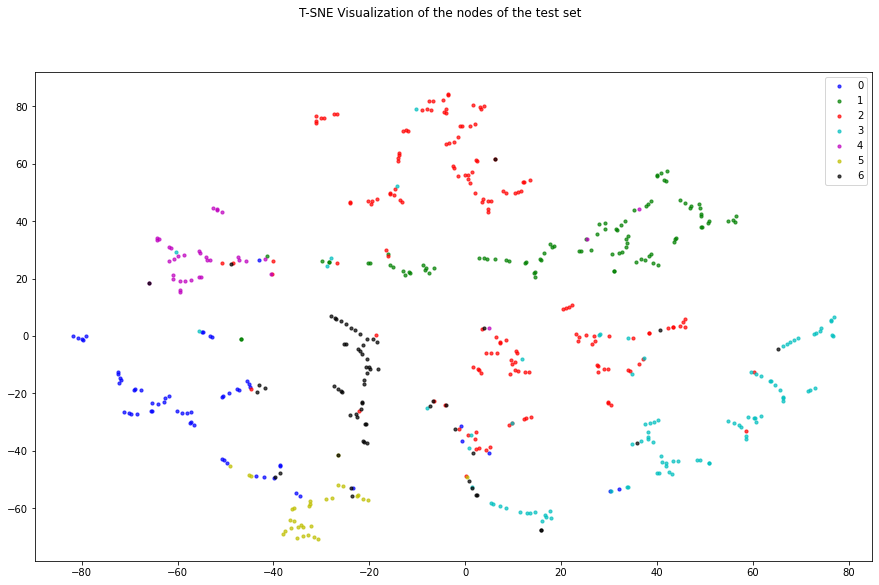

In [49]:

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix
embeddings_test = embeddings_test.detach().cpu().numpy()


# Projects the emerging representations to two dimensions using t-SNE

embeddings_test_2d = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embeddings_test)



labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()